# Lesson 8

### LSTM Network for Regression

Here we will develop an LSTM networks in Python using the Keras deep learning library to demonstrate a time-series prediction problem.

First we import some of the libraries, functions and classes we are going to use.  This assumes a working SciPy environment with the Keras deep learning library installed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# %matplotlib inline

Using TensorFlow backend.


It is recommended to fix the random number seed to ensure our results are reproducible.

In [2]:
# fix random seed for reproducibility
np.random.seed(0)

Our data set is $CO_2$ production in parts per million (ppm) from the volcano Mauna Loa (https://en.wikipedia.org/wiki/Mauna_Loa) between 1965-1980 by month. Data can be found here: https://datamarket.com/data/set/22v1/co2-ppm-mauna-loa-1965-1980#!ds=22v1&display=line

We will load the dataset using Pandas.  We are not interested in the date, given that each observation is separated by the same interval of one month.  Therefore, when we load the dataset we can exclude the first column.

The csv file has footer information that can be excluded with the skipfooter argument to pandas.read_csv() set to 3 for the 3 footer lines.  Once loaded we can visualize the dataset. 

In [3]:
# load the dataset
df = pd.read_csv('co2-ppm-mauna-loa-19651980.csv', usecols=[1], engine='python', skipfooter=3)
data = df.values
data = data.astype('float32')
print('Number of datapoints:',len(data))

Number of datapoints: 192


Let's visualize the data.  This data set has an upward trend over time as well as some periodicity.

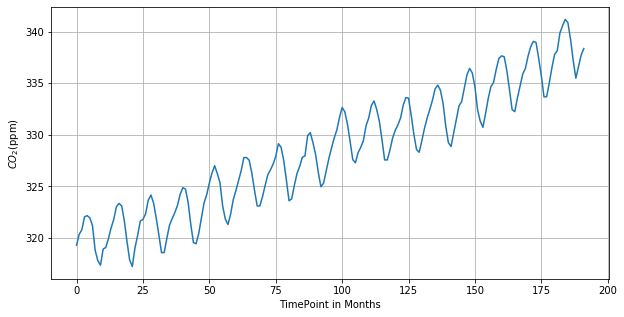

In [4]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in Months')
plt.ylabel('$CO_2$(ppm)')
plt.grid()
plt.plot(data);

With time series data, the sequence of the data is important. To create a train-test split we will use the first part of the sequence for training, and the latter part for testing.  The code below calculates the index of the split point and separates the data into the training set with 67% of the observations, and a training set with the remaining 33% of the observations.

In [5]:
# split into train and test sets
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
print('Train Set contains:', len(train),'datapoints')
print('Test Set contains:', len(test),'datapoints')

Train Set contains: 128 datapoints
Test Set contains: 64 datapoints


LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It is recommended to rescale (normalize) the data to the range of [0, 1]. This can be achieved using the MinMaxScaler preprocessing class from the scikit-learn library.

### Problem 1
Use the MinMaxScaler to normalize the training and testing set betwee 0 and 1.  Name the normalized outputs norm_train and norm_test.

In [6]:
# add code here




NameError: name 'norm_train' is not defined

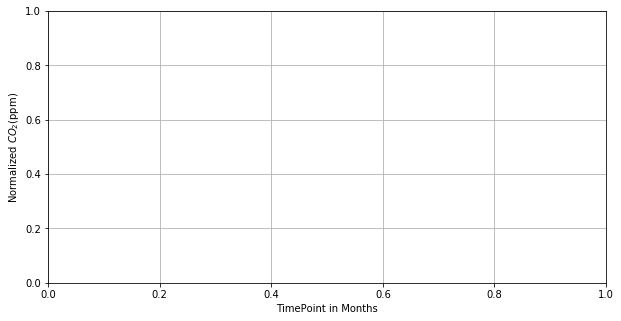

In [7]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in Months')
plt.ylabel('Normalized $CO_2$(ppm)')
plt.grid()
plt.plot(range(len(train)),norm_train,'b')
plt.plot(range(len(train),len(train)+len(test)),norm_test,'r')
plt.legend(['Norm Train','Norm Test']);

### Problem 2

We can write a function that separates the data into an input array (X) which has all the datapoint at times t-i's, and an output array which contains the data at timepoint t.

The function takes two arguments: the data, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — the default is 1.

In [8]:
def split_X_y(data, look_back = 1):
# add code here




SyntaxError: unexpected EOF while parsing (<ipython-input-8-aa5de5c6918c>, line 4)

In [ ]:
# reshape into X contains the data for times t-i ... t-2 t-1 and Y contains the data for times t
look_back = 1 # here we will only look at the previous datapoint to predict the next one
trainX, trainY = split_X_y(norm_train, look_back)
testX, testY = split_X_y(norm_test, look_back)

In [ ]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

The LSTM network expects the input data (X) to be provided in the form of: [sample, time steps, features].

Currently, the data is in the form: [samples, features], and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [9]:
# # reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

NameError: name 'trainX' is not defined

In [ ]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

We will now design and fit our LSTM network.

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 20 epochs and a batch size of 1 is used.

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Once the model is fit, we can estimate the performance of the model on both the training and testing datasets. 

Note that we must invert (un-normalize) the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (ppm per month).

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainYTrue = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testYTrue = scaler.inverse_transform(testY)

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainYTrue, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testYTrue, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Predictions have been generates using the model for both the train and test dataset. We can also visualize the results to have an indication for how the model works.

When plotting the data, we must shift the predictions by the look_back in time to align on the x-axis with the original dataset. The data is presented with the original dataset as black dots, the predictions for the training dataset in blue, and the predictions on the test dataset in red.

In [ ]:
plt.figure(figsize=[10,5])
plt.xlabel('TimePoint in Months')
plt.ylabel('$CO_2$(ppm)')
plt.grid()
plt.plot(range(len(data)),data,'k.')
plt.plot(range(look_back,len(trainPredict)+look_back),trainPredict,'b')
plt.plot(range(len(trainPredict)+2*look_back,len(trainPredict)+len(testPredict)+2*look_back),testPredict,'r')
plt.legend(['Actual','Train','Test']);

### Problem 3

Improve the results above by trying the following:
- Increase the number of epochs
- Increase the look_back value
- Modify the Architecture
- Other

In [ ]:
print('end')